In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from textblob import TextBlob
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import warnings
warnings.filterwarnings('ignore')

## Dataset

In [2]:
train = pd.read_csv('drugsComTrain_raw.csv', usecols=['drugName', 'condition', 'review', 'rating'])
test = pd.read_csv('drugsComTest_raw.csv', usecols=['drugName', 'condition', 'review', 'rating'])

In [3]:
print(f"Shape of train is {train.shape}")
print(f"Shape of test is {test.shape}")

Shape of train is (161297, 4)
Shape of test is (53766, 4)


In [4]:
train.head()

,drugName,condition,review,rating
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9


In [5]:
train.isnull().sum(), test.isnull().sum()

(drugName       0
 condition    899
 review         0
 rating         0
 dtype: int64,
 drugName       0
 condition    295
 review         0
 rating         0
 dtype: int64)

In [6]:
train.dropna(how='any', inplace = True)
test.dropna(how='any', inplace = True)

In [7]:
drugName_count_1 = len(set(train['drugName'].unique()))
condition_count_1 = len(set(train['condition'].unique()))

print(f'Number of unique Drugs in training dataset are {drugName_count_1}')
print(f"Number of unique conditions in training dataset are {condition_count_1}")

Number of unique Drugs in training dataset are 3431
Number of unique conditions in training dataset are 884


In [8]:
drugName_count_2 = len(set(test['drugName'].unique()))
condition_count_2 = len(set(test['condition'].unique()))

print(f'Number of unique Drugs in test dataset are {drugName_count_2}')
print(f"Number of unique conditions in test dataset are {condition_count_2}")

Number of unique Drugs in test dataset are 2635
Number of unique conditions in test dataset are 708


## Preprocessing Training Dataset

In [9]:
train.loc[(train['rating'] > 5), 'Review_Sentiment'] = 1
train.loc[(train['rating'] < 5), 'Review_Sentiment'] = -1
train.loc[(train['rating'] == 5), 'Review_Sentiment'] = 0

train['Review_Sentiment'].value_counts()

 1.0    112611
-1.0     39828
 0.0      7959
Name: Review_Sentiment, dtype: int64

In [10]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer

In [11]:
def review_clean(review): 
    review = review.lower()
    
    review = re.sub('&#039', '', review)
    review = re.sub(r'\W', ' ', review)
    review = re.sub(r'[^\x00-\x7F]+',' ', review)
    review = re.sub(r'\.{2,}', ' ', review)
    words = review.split()
#     all_stopwords = stopwords.words('english')
#     all_stopwords.remove('not')
    
    ps = PorterStemmer()
    ss = SnowballStemmer('english')
    
    words = [ss.stem(word) for word in words] #if not word in set(all_stopwords)]
    
    review = " ".join(words)
    
    return review

train['clean_review'] = train['review'].apply(review_clean)

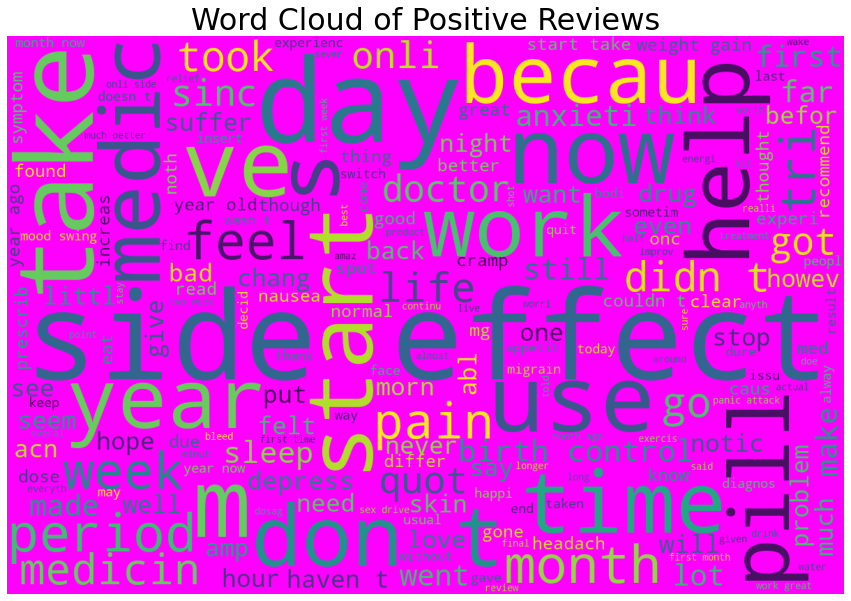

In [12]:
positive_sentiments = " ".join([text for text in train['clean_review'][train['Review_Sentiment'] == 1]])
wordcloud = WordCloud(background_color = 'magenta', width = 1200, height = 800).generate(positive_sentiments)

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Word Cloud of Positive Reviews', fontsize = 30)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

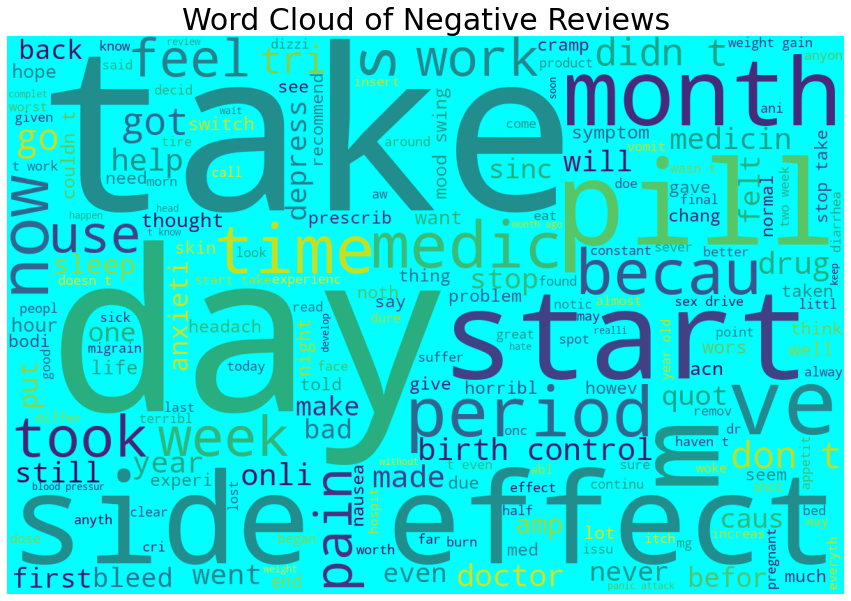

In [13]:
negative_sentiments = " ".join([text for text in train['clean_review'][train['Review_Sentiment'] == -1]])

wordcloud = WordCloud(background_color = 'cyan', width = 1200, height = 800).generate(negative_sentiments)

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Word Cloud of Negative Reviews', fontsize = 30)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

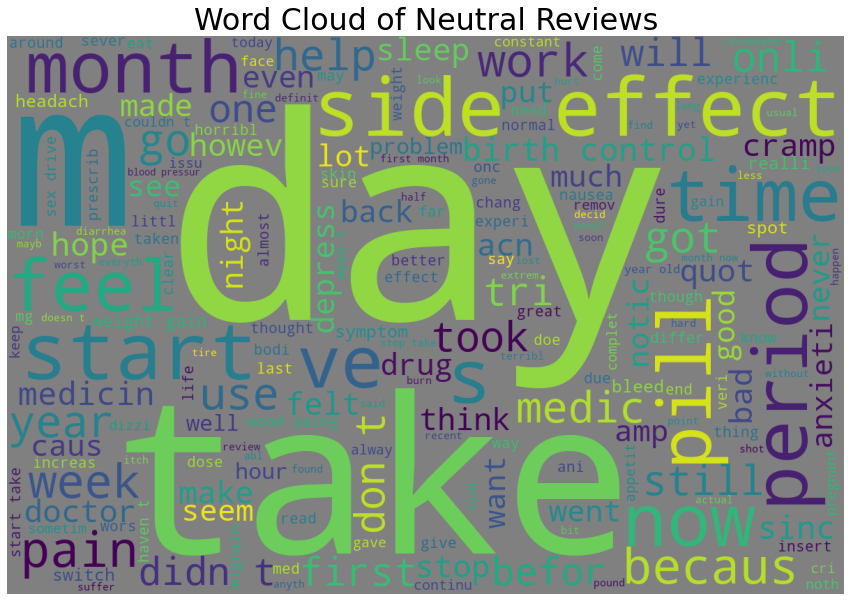

In [14]:
neutral_sentiments = " ".join([text for text in train['clean_review'][train['Review_Sentiment'] == 0]])

wordcloud = WordCloud(background_color = 'grey', width = 1200, height = 800).generate(neutral_sentiments)

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Word Cloud of Neutral Reviews', fontsize = 30)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

In [15]:
def get_polarity(text):
  return(TextBlob(text)).sentiment.polarity

train['polarity'] = train['clean_review'].apply(get_polarity)
train.head()

,drugName,condition,review,rating,Review_Sentiment,clean_review,polarity
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,1.0,it has no side effect i take it in combin of b...,0.000000
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,1.0,my son is halfway through his fourth week of i...,0.141071
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,0.0,i use to take anoth oral contracept which had ...,0.061607
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,1.0,this is my first time use ani form of birth co...,0.229167
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,1.0,suboxon has complet turn my life around i feel...,0.147037


In [16]:
print('Minimum:', min(train['polarity']), '----  Maximum:', max(train['polarity']))

Minimum: -1.0 ----  Maximum: 1.0


In [17]:
def analysis(score):
  if score < 0:
    return -1
  elif score == 0:
    return 0
  else:
    return 1

train['analysis'] = train['polarity'].apply(analysis)
train.head()

,drugName,condition,review,rating,Review_Sentiment,clean_review,polarity,analysis
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,1.0,it has no side effect i take it in combin of b...,0.000000,0
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,1.0,my son is halfway through his fourth week of i...,0.141071,1
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,0.0,i use to take anoth oral contracept which had ...,0.061607,1
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,1.0,this is my first time use ani form of birth co...,0.229167,1
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,1.0,suboxon has complet turn my life around i feel...,0.147037,1


In [18]:
from sklearn.feature_extraction.text import CountVectorizer

In [19]:
cv = CountVectorizer(ngram_range=(1, 2))

X_train = cv.fit_transform(train['clean_review'])
y_train = train['Review_Sentiment']

## Preprocessing Test Dataset 

In [20]:
test.loc[(test['rating'] > 5), 'Review_Sentiment'] = 1
test.loc[(test['rating'] < 5), 'Review_Sentiment'] = -1
test.loc[(test['rating'] == 5), 'Review_Sentiment'] = 0

test['Review_Sentiment'].value_counts()

 1.0    37352
-1.0    13428
 0.0     2691
Name: Review_Sentiment, dtype: int64

In [21]:
test['clean_review'] = test['review'].apply(review_clean)

In [22]:
test['polarity'] = test['clean_review'].apply(get_polarity)
test['analysis'] = test['polarity'].apply(analysis)

In [23]:
X_test = cv.transform(test['clean_review'])
y_test = test['Review_Sentiment']

## Training

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [25]:
for c in [0.01, 0.05, 0.25, 0.5, 1]:
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print(f"Accuracy for C = {c} : {accuracy_score(y_test, lr.predict(X_test))}")

Accuracy for C = 0.01 : 0.8584279328982065
Accuracy for C = 0.05 : 0.880065830076116
Accuracy for C = 0.25 : 0.8902769725645677
Accuracy for C = 0.5 : 0.8844981391782462
Accuracy for C = 1 : 0.8875465205438462


In [26]:
classifier = LogisticRegression(C= 0.25)
classifier.fit(X_train, y_train)
print (f"Final Accuracy by training Logistic Regression model is : {accuracy_score(y_test, classifier.predict(X_test))}")

Final Accuracy by training Logistic Regression model is : 0.8902769725645677


In [27]:
print(f"Final Accuracy of TextBlob on test set is: {accuracy_score(y_test, test['analysis'])}")

Final Accuracy of TextBlob on test set is: 0.5959866095640628


In [28]:
import pickle 

pickle.dump(classifier, open('Sentimental_model.sav', 'wb'))
pickle.dump(classifier, open('Sentimental_model.h5', 'wb'))